## Compute Welfares

In [1]:
# Define the various scenarios
N = 100
experiments = [
    dict(name='ces', param='xi', range=(0.2,1.0,N)),
    dict(name='exponential', param='alpha', range=(1,10,N)),
    dict(name='translog', param='alpha', range=(1,10,N))
]

In [2]:
def compute_case(expm):
    '''Evaluates welfare for the planner and the competitive equilibrium for various values of a specified parameter.
    
    Parameters
    ----------
    expm: dict
        Description of the experiment to perform. Contains several fields:
        - name: name of the experiment, the corresponding model file is expected to be model_*name*.yaml
        - param: name of the parameter to change
        - range: set of parameter values (min value, max value, N values)
    Returns
    -------
    df: pandas.DataFrame
        Each line contains:
        - parameter value
        - welfare for the planner optimum
        - welfare for the competitive equilibrium
    '''
        
    
    import pandas
    from dolo import yaml_import
    from dolo.algos.dtcscc.steady_state import find_deterministic_equilibrium
    from dolo.algos.dtcscc.perturbations_higher_order import approximate_controls
    from numpy import exp, array, linspace, column_stack

    
    case = expm['name']
    param = expm['param']
    range = expm['range']
    
    # create parameter range
    parm_vec = linspace(*range)
        
    # import model and get discount rate
    model = yaml_import('model_{}.yaml'.format(case))
    beta = model.get_calibration('beta')
    
    values_ce = []
    values_po = []
    
    # solve all calibrations
    for i in parm_vec:
        
        # Set calibrated parater value
        pp = {param:i}
        model.set_calibration(**pp)
        
        # Solve for the competitive equilibrium
        model.set_calibration(po=0)
        calib = find_deterministic_equilibrium(model)
        dr_ce = approximate_controls(model, order=2, steady_state=calib, verbose=False)

        # Solve for the social planner equilibrium
        model.set_calibration(po=1)
        calib = find_deterministic_equilibrium(model)
        dr_po = approximate_controls(model, order=2, steady_state=calib, verbose=False)     
        
                    
            
        # Initial point at which to evaluate the welfare
        eval_point = calib['states'].copy()
        # Change initial value of N
        eval_point[1]*=0.5 # to 50 % of its of its steady-state value
#         eval_point[1]=1    # to 1

        # Evalueate welfare
        w_ce = dr_ce(eval_point)[1]
        w_po = dr_po(eval_point)[1]
        
        # Convert to consumption equivalent
        v_ce = exp((1-beta)*w_ce)
        v_po = exp((1-beta)*w_po)
        
        # Add to list of values
        values_ce.append(v_ce)
        values_po.append(v_po)
    
   
    # Construct dataframe
    columns = [h.format(case) for h in ['{}_'+param, '{}_po', '{}_ce']]
    df = pandas.DataFrame( column_stack([parm_vec, values_po, values_ce]), columns=columns)
    
    return df

In [3]:
# parrallel evaluation (needs 3 workers)
# from IPython.parallel import Client
# rc = Client()
# dviews = rc[:3]
# all_welfares = dviews.map_sync(compute_case, experiments)

In [4]:
# serial evaluation
all_welfares = [compute_case(exp) for exp in experiments]

Model type detected as 'dtcscc'
Model type detected as 'dtcscc'
Model type detected as 'dtcscc'


In [5]:
# Add welfare gains to dataframe
import pandas
df = pandas.concat(all_welfares, axis=1)
# compute gains
for exp in experiments:
    case = exp['name']
    df['{}_gain'.format(case)] = (df['{}_po'.format(case)]/df['{}_ce'.format(case)]-1)*100
# save to Excel
df.to_excel('welfare_gains.xls')
df

,ces_xi,ces_po,ces_ce,exponential_alpha,exponential_po,exponential_ce,translog_alpha,translog_po,translog_ce,ces_gain,exponential_gain,translog_gain
0,0.200000,1.164332,1.132897,1.000000,0.690079,0.690052,1.000000,0.772007,0.762135,2.774785,0.003981,1.295232
1,0.208081,1.180358,1.152172,1.090909,0.701552,0.701526,1.090909,0.780831,0.771209,2.446277,0.003623,1.247621
2,0.216162,1.196917,1.171797,1.181818,0.711795,0.711771,1.181818,0.788680,0.779288,2.143679,0.003320,1.205182
3,0.224242,1.214013,1.191778,1.272727,0.721017,0.720995,1.272727,0.795723,0.786544,1.865649,0.003062,1.167024
4,0.232323,1.231648,1.212122,1.363636,0.729379,0.729358,1.363636,0.802090,0.793108,1.610960,0.002839,1.132462
5,0.240404,1.249828,1.232834,1.454545,0.737008,0.736989,1.454545,0.807883,0.799086,1.378487,0.002645,1.100954
6,0.248485,1.268557,1.253921,1.545455,0.744007,0.743989,1.545455,0.813185,0.804560,1.167196,0.002474,1.072068
7,0.256566,1.287840,1.275390,1.636364,0.750459,0.750441,1.636364,0.818062,0.809598,0.976134,0.002323,1.045454
8,0.264646,1.307684,1.297248,1.727273,0.756432,0.756416,1.727273,0.822568,0.814256,0.804422,0.002188,1.020823
9,0.272727,1.328095,1.319502,1.818182,0.761984,0.761968,1.818182,0.826748,0.818579,0.651247,0.002067,0.997938


## Make plots

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

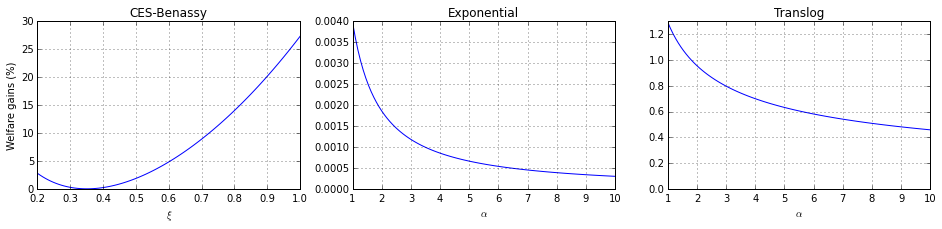

In [7]:
fig = plt.figure(figsize=(16,3))
plt.subplot(131)
plt.plot(df['ces_xi'],df['ces_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\xi$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-Benassy")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(132)
plt.plot(df['exponential_alpha'],df['exponential_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Exponential")
plt.xlabel("$\\alpha$")
plt.subplot(133)
plt.plot(df['translog_alpha'],df['translog_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Translog")
plt.xlabel("$\\alpha$")
plt.savefig('BGM_welfare_gains.png')
plt.savefig('BGM_welfare_gains.pdf')
plt.savefig('BGM_welfare_gains.svg')


In [8]:
## optional: export with plotly
from plotly import plotly
link = plotly.plot_mpl(fig, filename='BGM_welfare_gains')

/home/pablo/.local/opt/anaconda/lib/python2.7/site-packages/plotly/matplotlylib/renderer.py:514: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

